# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""
Build your own model
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-2, 1e-3, 1e-4]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
OPTIMIZER = ['SGD', 'RMSprop', 'AdaGrad', 'Adam']

In [7]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for opt in OPTIMIZER:
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("\n\nExperiment with Optimizer = %s, Learning Rate = %.4f" % (opt, lr))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        
        optimizer = {
            'SGD': lambda: keras.optimizers.SGD(learning_rate=lr, nesterov=True, momentum=MOMENTUM),
            'RMSprop': lambda: keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
            'AdaGrad': lambda: keras.optimizers.Adagrad(learning_rate=lr),
            'Adam': lambda: keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
        }.get(opt)
        
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer())
        
        model.fit(x_train, y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test, y_test),
                  shuffle=True)
        
        # Score trained model.
        scores = model.evaluate(x_test, y_test, verbose=1)
        print('Test loss:', scores[0])
        print('Test accuracy:', scores[1])
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_name_tag = "exp-opt-%s-lr-%s" % (str(opt), str(lr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}




Experiment with Optimizer = SGD, Learning Rate = 0.0100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1

50000/50000 [==============================] - 9s 179us/step - loss: 0.3848 - accuracy: 0.8613 - val_loss: 2.2373 - val_accuracy: 0.5215
Epoch 49/50
50000/50000 [==============================] - 9s 181us/step - loss: 0.3871 - accuracy: 0.8602 - val_loss: 2.2755 - val_accuracy: 0.5189
Epoch 50/50
10000/10000 [==============================] - 1s 124us/step
Test loss: 2.3445293769836426
Test accuracy: 0.5238000154495239


Experiment with Optimizer = SGD, Learning Rate = 0.0010
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________________

50000/50000 [==============================] - 9s 186us/step - loss: 0.9461 - accuracy: 0.6666 - val_loss: 1.4172 - val_accuracy: 0.5260
Epoch 45/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.9326 - accuracy: 0.6693 - val_loss: 1.3779 - val_accuracy: 0.5308
Epoch 46/50
50000/50000 [==============================] - 9s 176us/step - loss: 0.9250 - accuracy: 0.6734 - val_loss: 1.3893 - val_accuracy: 0.5243
Epoch 47/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.9149 - accuracy: 0.6797 - val_loss: 1.3838 - val_accuracy: 0.5261
Epoch 48/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.8945 - accuracy: 0.6849 - val_loss: 1.4079 - val_accuracy: 0.5279
Epoch 49/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.8869 - accuracy: 0.6885 - val_loss: 1.4571 - val_accuracy: 0.5189
Epoch 50/50
10000/10000 [==============================] - 1s 111us/step
Test loss: 1.4329769653320312
Test accuracy: 

Epoch 41/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.6026 - accuracy: 0.4397 - val_loss: 1.6116 - val_accuracy: 0.4370
Epoch 42/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.5984 - accuracy: 0.4414 - val_loss: 1.6100 - val_accuracy: 0.4352
Epoch 43/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.5938 - accuracy: 0.4420 - val_loss: 1.6043 - val_accuracy: 0.4403
Epoch 44/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.5892 - accuracy: 0.4441 - val_loss: 1.6024 - val_accuracy: 0.4396
Epoch 45/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.5841 - accuracy: 0.4482 - val_loss: 1.5948 - val_accuracy: 0.4442
Epoch 46/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.5796 - accuracy: 0.4478 - val_loss: 1.5938 - val_accuracy: 0.4397
Epoch 47/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.5751 - accuracy: 0.4513

50000/50000 [==============================] - 9s 183us/step - loss: 1.7386 - accuracy: 0.3739 - val_loss: 1.9646 - val_accuracy: 0.3228
Epoch 38/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.7341 - accuracy: 0.3733 - val_loss: 1.8126 - val_accuracy: 0.3584
Epoch 39/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.7369 - accuracy: 0.3755 - val_loss: 1.7861 - val_accuracy: 0.3491
Epoch 40/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.7312 - accuracy: 0.3743 - val_loss: 1.8885 - val_accuracy: 0.3408
Epoch 41/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.7264 - accuracy: 0.3781 - val_loss: 2.1047 - val_accuracy: 0.3079
Epoch 42/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.7351 - accuracy: 0.3763 - val_loss: 1.7842 - val_accuracy: 0.3555
Epoch 43/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.7274 - accuracy: 0.3749 - val_loss:

50000/50000 [==============================] - 9s 185us/step - loss: 0.9969 - accuracy: 0.6427 - val_loss: 1.8174 - val_accuracy: 0.4604
Epoch 34/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.9812 - accuracy: 0.6492 - val_loss: 1.7982 - val_accuracy: 0.4502
Epoch 35/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9686 - accuracy: 0.6556 - val_loss: 1.7387 - val_accuracy: 0.4779
Epoch 36/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.9535 - accuracy: 0.6585 - val_loss: 1.7324 - val_accuracy: 0.4729
Epoch 37/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9364 - accuracy: 0.6655 - val_loss: 1.7270 - val_accuracy: 0.4882
Epoch 38/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9229 - accuracy: 0.6703 - val_loss: 1.8015 - val_accuracy: 0.4592
Epoch 39/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.9091 - accuracy: 0.6761 - val_loss:

50000/50000 [==============================] - 10s 191us/step - loss: 1.1695 - accuracy: 0.5902 - val_loss: 1.4931 - val_accuracy: 0.4758
Epoch 30/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.1565 - accuracy: 0.5947 - val_loss: 1.4072 - val_accuracy: 0.5016
Epoch 31/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.1432 - accuracy: 0.6000 - val_loss: 1.4052 - val_accuracy: 0.5117
Epoch 32/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.1306 - accuracy: 0.6038 - val_loss: 1.3513 - val_accuracy: 0.5234
Epoch 33/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.1234 - accuracy: 0.6064 - val_loss: 1.4451 - val_accuracy: 0.4972
Epoch 34/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.1080 - accuracy: 0.6130 - val_loss: 1.3455 - val_accuracy: 0.5293
Epoch 35/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.0978 - accuracy: 0.6181 - val_loss

50000/50000 [==============================] - 9s 182us/step - loss: 1.2772 - accuracy: 0.5484 - val_loss: 1.4014 - val_accuracy: 0.5029
Epoch 26/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2637 - accuracy: 0.5539 - val_loss: 1.4525 - val_accuracy: 0.4829
Epoch 27/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2568 - accuracy: 0.5564 - val_loss: 1.4079 - val_accuracy: 0.5034
Epoch 28/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2440 - accuracy: 0.5616 - val_loss: 1.4865 - val_accuracy: 0.4719
Epoch 29/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2375 - accuracy: 0.5625 - val_loss: 1.4518 - val_accuracy: 0.4924
Epoch 30/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2263 - accuracy: 0.5671 - val_loss: 1.4198 - val_accuracy: 0.5001
Epoch 31/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2152 - accuracy: 0.5727 - val_loss:

Epoch 22/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4046 - accuracy: 0.5094 - val_loss: 1.4861 - val_accuracy: 0.4707
Epoch 23/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.3955 - accuracy: 0.5136 - val_loss: 1.4534 - val_accuracy: 0.4851
Epoch 24/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.3875 - accuracy: 0.5170 - val_loss: 1.4415 - val_accuracy: 0.4917
Epoch 25/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.3803 - accuracy: 0.5192 - val_loss: 1.4455 - val_accuracy: 0.4904
Epoch 26/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.3749 - accuracy: 0.5206 - val_loss: 1.4570 - val_accuracy: 0.4816
Epoch 27/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.3681 - accuracy: 0.5231 - val_loss: 1.5022 - val_accuracy: 0.4685
Epoch 28/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.3607 - accuracy: 0.5260

50000/50000 [==============================] - 9s 176us/step - loss: 1.7385 - accuracy: 0.3965 - val_loss: 1.7405 - val_accuracy: 0.3973
Epoch 19/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.7341 - accuracy: 0.3987 - val_loss: 1.7376 - val_accuracy: 0.3975
Epoch 20/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.7298 - accuracy: 0.4017 - val_loss: 1.7342 - val_accuracy: 0.3992
Epoch 21/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.7259 - accuracy: 0.4025 - val_loss: 1.7289 - val_accuracy: 0.3991
Epoch 22/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.7220 - accuracy: 0.4043 - val_loss: 1.7252 - val_accuracy: 0.4033
Epoch 23/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.7181 - accuracy: 0.4051 - val_loss: 1.7221 - val_accuracy: 0.4034
Epoch 24/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.7147 - accuracy: 0.4056 - val_loss:

50000/50000 [==============================] - 11s 219us/step - loss: 1.5338 - accuracy: 0.4485 - val_loss: 1.6558 - val_accuracy: 0.4180
Epoch 15/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.5451 - accuracy: 0.4450 - val_loss: 1.5915 - val_accuracy: 0.4330
Epoch 16/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.5362 - accuracy: 0.4498 - val_loss: 1.6110 - val_accuracy: 0.4193
Epoch 17/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.5278 - accuracy: 0.4520 - val_loss: 1.5634 - val_accuracy: 0.4431
Epoch 18/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.5301 - accuracy: 0.4512 - val_loss: 1.5717 - val_accuracy: 0.4395
Epoch 19/50
50000/50000 [==============================] - 11s 225us/step - loss: 1.5204 - accuracy: 0.4588 - val_loss: 1.5832 - val_accuracy: 0.4333
Epoch 20/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.5213 - accuracy: 0.4549 - va

50000/50000 [==============================] - 11s 218us/step - loss: 1.3597 - accuracy: 0.5154 - val_loss: 1.4150 - val_accuracy: 0.5002
Epoch 11/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.3279 - accuracy: 0.5280 - val_loss: 1.4235 - val_accuracy: 0.4964
Epoch 12/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.3012 - accuracy: 0.5366 - val_loss: 1.4140 - val_accuracy: 0.4999
Epoch 13/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.2836 - accuracy: 0.5428 - val_loss: 1.4040 - val_accuracy: 0.5082
Epoch 14/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.2564 - accuracy: 0.5520 - val_loss: 1.4093 - val_accuracy: 0.5008
Epoch 15/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.2334 - accuracy: 0.5629 - val_loss: 1.3740 - val_accuracy: 0.5124
Epoch 16/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.2131 - accuracy: 0.5679 - va

50000/50000 [==============================] - 11s 213us/step - loss: 1.4978 - accuracy: 0.4730 - val_loss: 1.5106 - val_accuracy: 0.4687
Epoch 7/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.4653 - accuracy: 0.4863 - val_loss: 1.4915 - val_accuracy: 0.4699
Epoch 8/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.4333 - accuracy: 0.4964 - val_loss: 1.4619 - val_accuracy: 0.4873
Epoch 9/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.4130 - accuracy: 0.5055 - val_loss: 1.4480 - val_accuracy: 0.4854
Epoch 10/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.3804 - accuracy: 0.5170 - val_loss: 1.4428 - val_accuracy: 0.4865
Epoch 11/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.3637 - accuracy: 0.5224 - val_loss: 1.4557 - val_accuracy: 0.4843
Epoch 12/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.3448 - accuracy: 0.5299 - val_l

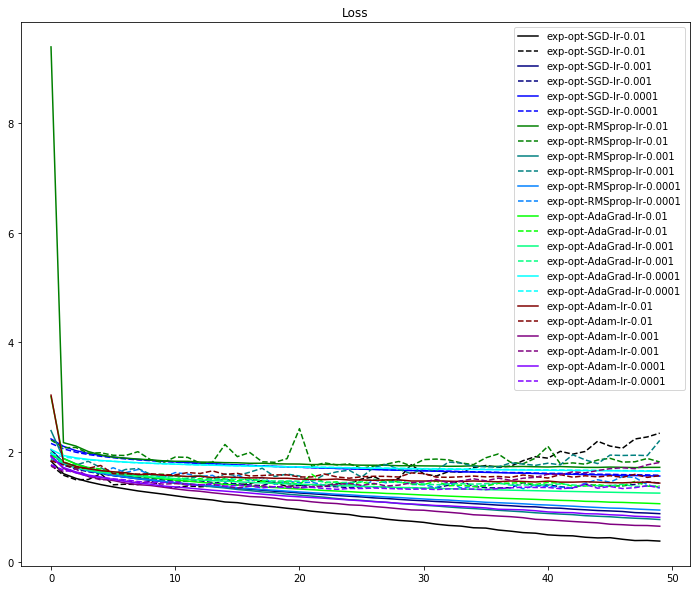

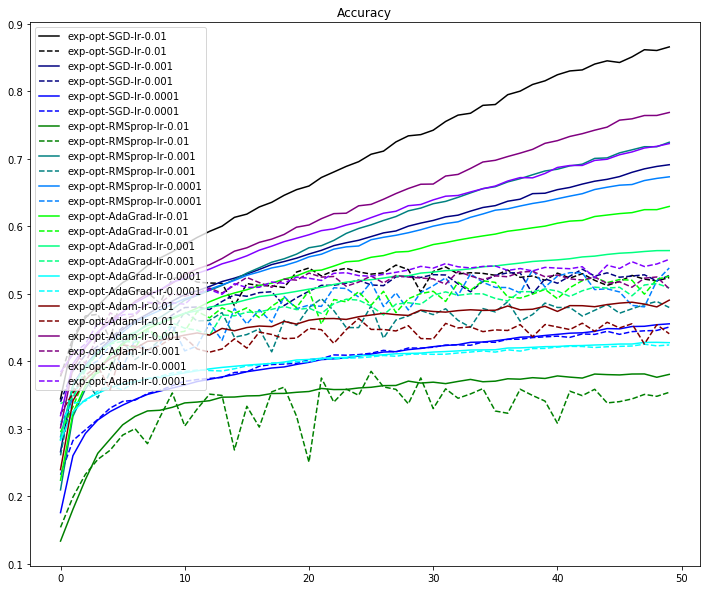

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['#000000', '#000080', '#0000ff', '#008000',
             '#008080', '#0080ff', '#00ff00', '#00ff80',
             '#00ffff', '#800000', '#800080', '#8000ff']

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc = 'upper right')
plt.show()

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc = 'upper left')
plt.show()